# Mouvement Brownien

In [18]:
#Mouvement brownien
import numpy as np
import random
import matplotlib.pyplot as plt
def Brown(S, n, alpha, sigma): 
    L=[[0,S]]                                  # Je mettrai mes points dans une liste abscisse/ordonnée pour les tracer plus tard
    W = 0                                      # represente la valeur du brownien
    for i in range(n):
    # Je génère deux lois uniformes sur [0,1] 
        u=random.uniform(0,1)       
        v=random.uniform(0,1)
        # genere: dW = increment brownien
        dW=np.sqrt(-2*np.log(u)*(1.0)/float(n))*np.cos(2*np.pi*v)         # Je génère une loi normale centrée réduite de variance t=1/n 
        #donc la valeur du brownien au temps t=(i+1)/n est
        W=W+dW
        #on stocke tout ca dans la liste L
        L.append([i+1, S*np.exp(sigma*W-(1/2*sigma**2-alpha)*(i+1)/n)])   
    return L

In [19]:
def BS_mvt(S, n, sigma,r,T):
    L=[]
    L.append(S)
    for i in range(1,n):
        L.append(L[i-1]*(1+r*T/n+sigma*random.gauss(0,1)*np.sqrt(T/n)))
    plt.plot(L)
    return L
    

# Longstaff Schwartz pour le pricing des americaines

# Description de la méthode :

L'intuition derrière cette méthode, c'est qu'à tout moment de l'exercice, l'acheteur d'une option américaine compare de manière dynamique le gain de l'exercice immédiat avec le gain escompté de la poursuite, et puis s'exerce si le gain immédiat est plus élevé.
Ainsi, l'exercice optimal est fondamentalement déterminée par l'espérance conditionnelle de continuer à maintenir cette option. L'idée clé qui sous-tend notre approche est que cette espérance conditionnelle peut être estimée en utilisant les moindres carrés. Plus précisément, nous régressons les gains réalisés à posteriori en fonction du prix du sous-jacent à t-1. La valeur ajustée de cette régression fournit une estimation directe de la fonction d'espérance conditionnelle. En estimant la fonction d'espérance conditionnelle pour chaque date d'exercice, on obtient la valeur de l'option américaine.

# La régession :
La régression se fait en utilisant un polynome de degré 2 que sur les valeurs in-the money.
![title](img/reg.png)
# Choix du chemin :
Le choix du chemin optimal se fait en comparant le gain d'exercice (estimé en utilisant la régression linéaire) et le payoff de la continuation.
![title](img/choix.png)

In [20]:
def AMC(S, n, sigma,r,T,K,scenarios,call=True):
    X=[]
    for i in range(scenarios):  
        X.append(BS_mvt(S, n, sigma,r,T))
    X=np.array(X).reshape(n,scenarios)

    df = np.exp(-r*T/n)
    if (call==True):
        payoff = np.maximum(-K + X, 0)
    else:
        payoff = np.maximum(K - X, 0)

    #Matrice des valeurs
    matrix = np.zeros_like(payoff) 
    matrix[:,-1] = payoff[:,-1]

    # Boucle
    for t in range(n-2, 0, -1):

        chemins_choisis = payoff[:,t] > 0        # Les chemins où la valeur est positive 
                                        
        #regression linéaire
        regressor = np.polyfit( X[chemins_choisis, t], matrix[chemins_choisis, t+1] * df, 2)    
        result = np.polyval( regressor, X[chemins_choisis,t] )                             

        #Init
        exercise = np.zeros( len(chemins_choisis), dtype=bool)   
         
        #Chemins d exercicse
        exercise[chemins_choisis] = payoff[chemins_choisis,t] > result     

        matrix[exercise,t] = payoff[exercise,t]                        
        matrix[exercise,t+1:] = 0  
        
        #Chemins de non exercice
        chemin_non_exercice = (matrix[:,t] == 0)   
        
        #Remplir la matrice des valeurs
        matrix[chemin_non_exercice,t] = matrix[chemin_non_exercice,t+1] * df       

    price = np.mean(matrix[:,1]) * df 
    print("Price= ", price)
    return price

## Test

Conditions: S0 = 50.000000 Strike = 50.000000 sigma = 0.300000 Taux d'interet = 0.050000 Maturite = 1.000000 Nombre de chemins = 0
prix du call :
Price=  7.238649349450261
prix du put :
Price=  5.006526326725851


5.006526326725851

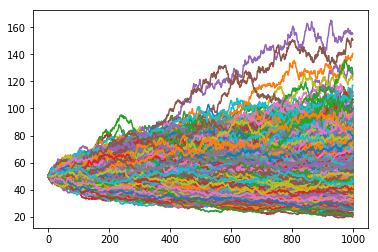

In [39]:
K=50
S=int(50)
n=1000
sigma=0.3
r=0.05
T=1
scenarios=1000

print('Conditions: S0 = %f Strike = %f sigma = %f Taux d\'interet = %f Maturite = %f Nombre de chemins = %d' % (K,S,sigma,r,T,b))

print('prix du call :')
call=True
AMC(S, n, sigma,r,T,K,scenarios,call)

print('prix du put :')
call=False
AMC(S, n, sigma,r,T,K,scenarios,call)

# Formule fermée de BS pour les américaines :
## Approximation de Bjerksund & Stensland
### Forumation :
![title](img/formulation.png)

Le b désigne le cost of carry de l'action.

### Put en fonction du call
![title](img/put_call.png)

### Fonctions utiles

In [14]:
def psi(fs, t2, gamma, h, i2, i1, t1, r, b, v):
    vsqrt_t1 = v * math.sqrt(t1)
    vsqrt_t2 = v * math.sqrt(t2)

    bgamma_t1 = (b + (gamma - 0.5) * (v ** 2)) * t1
    bgamma_t2 = (b + (gamma - 0.5) * (v ** 2)) * t2

    d1 = (math.log(fs / i1) + bgamma_t1) / vsqrt_t1
    d3 = (math.log(fs / i1) - bgamma_t1) / vsqrt_t1

    d2 = (math.log((i2 ** 2) / (fs * i1)) + bgamma_t1) / vsqrt_t1
    d4 = (math.log((i2 ** 2) / (fs * i1)) - bgamma_t1) / vsqrt_t1

    e1 = (math.log(fs / h) + bgamma_t2) / vsqrt_t2
    e2 = (math.log((i2 ** 2) / (fs * h)) + bgamma_t2) / vsqrt_t2
    e3 = (math.log((i1 ** 2) / (fs * h)) + bgamma_t2) / vsqrt_t2
    e4 = (math.log((fs * (i1 ** 2)) / (h * (i2 ** 2))) + bgamma_t2) / vsqrt_t2

    tau = math.sqrt(t1 / t2)
    lambda1 = (-r + gamma * b + 0.5 * gamma * (gamma - 1) * (v ** 2))
    kappa = (2 * b) / (v ** 2) + (2 * gamma - 1)

    psi = math.exp(lambda1 * t2) * (fs ** gamma) * (cbnd(-d1, -e1, tau)
                                                    - ((i2 / fs) ** kappa) * cbnd(-d2, -e2, tau)
                                                    - ((i1 / fs) ** kappa) * cbnd(-d3, -e3, -tau)
                                                    + ((i1 / i2) ** kappa) * cbnd(-d4, -e4, -tau))
    return psi



def phi(fs, t, gamma, h, i, r, b, v):
    d1 = -(math.log(fs / h) + (b + (gamma - 0.5) * (v ** 2)) * t) / (v * math.sqrt(t))
    d2 = d1 - 2 * math.log(i / fs) / (v * math.sqrt(t))

    lambda1 = (-r + gamma * b + 0.5 * gamma * (gamma - 1) * (v ** 2))
    kappa = (2 * b) / (v ** 2) + (2 * gamma - 1)

    phi = math.exp(lambda1 * t) * (fs ** gamma) * (norm.cdf(d1) - ((i / fs) ** kappa) * norm.cdf(d2))

    return phi

def cbnd(a, b, rho):
    down = np.array([0, 0])
    up = np.array([a, b])
    infin = np.array([0, 0])
    correlation = rho
    error, value, inform = mvn.mvndst(down, up, infin, correlation)
    return value

#### Fonction principale :

In [22]:
import unittest
import math
import numpy as np
from scipy.stats import norm
from scipy.stats import mvn
from scipy.stats import norm
import math
def BS_american_closed_form(S, K, T, r, b, sigma,call):
    
    if call==False:
        aux=S
        S=K
        K=aux
        r=r-b
        b=-b
        
    #calcul des paramètres:
    t__sqrt = math.sqrt(T)
    d1 = (math.log(S / K) + (b + (sigma * sigma) / 2) * T) / (sigma * t__sqrt)
    d2 = d1 - sigma * t__sqrt

    price_euro = S * math.exp((b - r) * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    delta = math.exp((b - r) * T) * norm.cdf(d1)
    gamma = math.exp((b - r) * T) * norm.pdf(d1) / (S * sigma * t__sqrt)
    theta = -(S * sigma * math.exp((b - r) * T) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * S * math.exp((b - r) * T) * norm.cdf(d1) - r * K * math.exp(-r * T) * norm.cdf(d2)
    vega = math.exp((b - r) * T) * S * t__sqrt * norm.pdf(d1)
    rho = K * T * math.exp(-r * T) * norm.cdf(d2)
        
    # Si b >= r, ce n'est pas optimal d'exercer avant la maturité
    if b >= r:
        return price_euro
    
    #Deuxième étape de calculs:
    v2 = sigma ** 2
    t1 = 0.5 * (math.sqrt(5) - 1) * T
    t2 = T

    beta_inside = ((b / v2 - 0.5) ** 2) + 2 * r / v2
   
    beta_inside = abs(beta_inside)
    beta = (0.5 - b / v2) + math.sqrt(beta_inside)
    b_infinity = (beta / (beta - 1)) * K
    b_zero = max(K, (r / (r - b)) * K)

    h1 = -(b * t1 + 2 * sigma * math.sqrt(t1)) * ((K ** 2) / ((b_infinity - b_zero) * b_zero))
    h2 = -(b * t2 + 2 * sigma * math.sqrt(t2)) * ((K ** 2) / ((b_infinity - b_zero) * b_zero))

    i1 = b_zero + (b_infinity - b_zero) * (1 - math.exp(h1))
    i2 = b_zero + (b_infinity - b_zero) * (1 - math.exp(h2))

    alpha1 = (i1 - K) * (i1 ** (-beta))
    alpha2 = (i2 - K) * (i2 ** (-beta))

    # Vérification d'exercice immédiat
    if S >= i2:
        price = S - K
    else:
        #Calcul principal    
        price = (alpha2 * (S ** beta)
                 - alpha2 * phi(S, t1, beta, i2, i2, r, b, sigma)
                 + phi(S, t1, 1, i2, i2, r, b, sigma)
                 - phi(S, t1, 1, i1, i2, r, b, sigma)
                 - K * phi(S, t1, 0, i2, i2, r, b, sigma)
                 + K * phi(S, t1, 0, i1, i2, r, b, sigma)
                 + alpha1 * phi(S, t1, beta, i1, i2, r, b, sigma)
                 - alpha1 * psi(S, t2, beta, i1, i2, i1, t1, r, b, sigma)
                 + psi(S, t2, 1, i1, i2, i1, t1, r, b, sigma)
                 - psi(S, t2, 1, K, i2, i1, t1, r, b, sigma)
                 - K * psi(S, t2, 0, i1, i2, i1, t1, r, b, sigma)
                 + K * psi(S, t2, 0, K, i2, i1, t1, r, b, sigma))

    
    price = max(price, price_euro)

    return price
    

    

#### Tests et vérifications:

![title](img/test.png)

In [40]:
K=100
S=100
sigma=0.2
r=0.08
T=0.25
b=-0.04

print('Conditions: S0 = %f Strike = %f sigma = %f Taux d\'interet = %f Maturite = %f Cost of carry = %f' % (K,S,sigma,r,T,b))

call=True
print('Prix du call')
print(BS_american_closed_form(S, K, T, r, b, sigma,call))

call=False
print('Prix du put')
print(BS_american_closed_form(S, K, T, r, b, sigma,call))


Conditions: S0 = 100.000000 Strike = 100.000000 sigma = 0.200000 Taux d'interet = 0.080000 Maturite = 0.250000 Cost of carry = -0.040000
Prix du call
3.500267403291197
Prix du put
4.396422828327907
